In [1]:
# Required Python utilities
import numpy as np
import pandas as pd

from collections import Counter
import re
from langdetect import detect
from bs4 import BeautifulSoup
from markdown import markdown
from lxml import etree
import os
import random
import tqdm
import itertools 
import pickle

## Deep Learning imports for the classifiers
os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Concatenate
from keras.models import Model

##Â ML required imports (for clustering)
from sklearn import metrics
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN


# Topic modeling imports
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

##Â NLP related imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer


# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set() 

Using Theano backend.


In [2]:
## Configuration of this notebook
BASE_DIR = "./Data/VALIDATED_DATA/"


FLAG__COLLECT_NEW_DATA_FROM_GITHUB = False
FLAG__GENERATE_NEW_TRAINING_FILES = False
FLAG__RETRAIN_MODELS = False
FLAG__RETRAIN_DOC2VEC_MODEL = False

In [3]:
## Classificaiton NETWORKs Configuration parameters
MAX_SEQUENCE_LENGTH = 32
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100 ## 100, 200 or 300
VALIDATION_SPLIT = 0.2

NUM_EPOCHS = 20

# 1. Read knowledge base files

This code expects one file per convention/characteristic. It reads all files in the given folder so documents for conventions and characteristics should be placed in different directories.

In [4]:
## Reading GLOVE (precalculated word embeddings)
GLOVE_DIR = ""
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.{}d.txt'.format(EMBEDDING_DIM)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [5]:
print('Total {} word vectors in Glove 6B {}d.'.format(len(embeddings_index), EMBEDDING_DIM))

Total 400000 word vectors in Glove 6B 100d.


## 1.1 Conventions files

In [6]:
CONVENTIONS_DIR = os.path.join(BASE_DIR, "Conventions")

convention_files = [f for f in os.listdir(CONVENTIONS_DIR) if (os.path.isfile(os.path.join(CONVENTIONS_DIR, f)) and not f.startswith( '.' ) and not "random" in f and not "training_" in f)]
convention_files

['Industrial.txt',
 'Civic.txt',
 'Domestic.txt',
 'Market.txt',
 'Renown.txt',
 'Project.txt',
 'Green.txt',
 'Inspired.txt']

## 1.2 Software characteristics files

List of software characteristics:
- **Advantages** : Advantages corresponds to a comparison between the capabilities of two or more software products. This comparison often sets clearly one of them in a better place.
- **Contributions** : Contributors in github are software developers who are participating in the task of building a Github project. In this category, we look for sentences explicitly mentioning and/or looking for contributions to a given project.
- **Efficiency** : Efficiency describes the amount of system resources that a piece of software require for executing a certain task. Related to this, there is the term 'scalability'. Scalability is the property of a system to handle a growing amount of work by adding resources to the system.
- **Functionalities** : Software functionalities and features are distinguishing characteristics of a software item, describing capabilities of the item.
- **Licensing** : A software license is a legal instrument governing the use or redistribution of software.
- **Portability** : Software portability describes the process of adapting software for the purpose of achieving some form of execution in a computing environment that is different from the one that a given program (meant for such execution) was originally designed for.
- **Reliability/Maintainability** : Reliability is an attribute of resiliency and structural solidity. Reliability measures the level of risk and the likelihood of potential application failures. Maintainability describes the easiness of a software to be understood, repaired or enhanced.
- **Usability** : Usability in software engineering, is the degree to which a software can be used by specified consumers to achieve quantified objectives with effectiveness, efficiency, and satisfaction in a quantified context of use.


In [7]:
SOFTWARE_CHARS_DIR = os.path.join(BASE_DIR, "Software_characteristics")

characteristics_files = [f for f in os.listdir(SOFTWARE_CHARS_DIR) if (os.path.isfile(os.path.join(SOFTWARE_CHARS_DIR, f)) and not f.startswith( '.' ) and not "random" in f and not "training_" in f)]
characteristics_files

['portability.txt',
 'reliability:maintanability.txt',
 'efficiency.txt',
 'advantages.txt',
 'licensing.txt',
 'functionalities.txt',
 'usability.txt',
 'contributions.txt']

# 2. Github data gathering

## 2.1 Using Github's API

In [8]:
#import github
from github import Github

In [9]:
## Configuration
##Â Please, use your own access token for the Github API!
ACCESS_TOKEN = "" #TO BE REMOVED

In [10]:
## Initializing Github connection (user authentication)
g = Github(ACCESS_TOKEN)

In [11]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    repositories = g.search_repositories(query='topic:machine-learning')

In [12]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    repos_descriptions = []
    repos_names = []
    repos_creation_dates = []
    repos_ids = []
    repos_languages = []
    repos_owners = []
    repos_topics = []

    repos_num_stars = []
    repos_num_subscribers = []
    repos_num_watchers = []

In [13]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    for r in tqdm.tqdm(repositories[:1050]):

        all_right_flag = True
        try:

            # Repository metadata
            repo_name = r.full_name
            repo_creation_date = r.created_at
            repo_id = r.id
            repo_language = r.language
            repo_owner = r.owner
            repo_topics = r.get_topics()

             # Repository fame
            repo_num_stars = r.stargazers_count ##Â Count of stars
            repo_num_subscribers = r.subscribers_count    ##Â Number of subscribers
            repo_num_watchers = r.watchers_count    ##Â Number of subscribers  

            repo_raw_description = str(r.get_contents("README.md").decoded_content).lower() ## README file content

            if detect(repo_raw_description) != 'en':
                all_right_flag=False
                
        except Exception as e:
            print(e)
            all_right_flag = False

        if all_right_flag: ##Â Check there was no error on obtaining the information

            ## Adding information to the arrays
            repos_descriptions.append(repo_raw_description)
            repos_names.append(repo_name)
            repos_creation_dates.append(repo_creation_date)
            repos_ids.append(repo_id)
            repos_languages.append(repo_language)
            repos_owners.append(repo_owner)
            repos_topics.append(repo_topics)

            repos_num_stars.append(repo_num_stars)
            repos_num_subscribers.append(repo_num_subscribers)
            repos_num_watchers.append(repo_num_watchers)

## 2.2 Formatting the information into a dataframe

In [15]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    col_names = ["repo_name","repo_creation_date","repo_id","repo_language","repo_owner","repo_topics","repo_num_stars","repo_num_subscribers","repo_num_watchers","repo_raw_description"]

In [16]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    ## Creating empty dataframe
    df = pd.DataFrame(columns = col_names)

    ## Adding columns information to the dataframe
    df["repo_name"] = repos_names
    df["repo_creation_date"] = repos_creation_dates
    df["repo_id"] = repos_ids
    df["repo_language"] = repos_languages
    df["repo_owner"] = repos_owners
    df["repo_topics"] = repos_topics
    df["repo_num_stars"] = repos_num_stars
    df["repo_num_subscribers"] = repos_num_subscribers
    df["repo_num_watchers"] = repos_num_watchers
    df["repo_raw_description"] = repos_descriptions
    
    df.head()

## 2.3 Processing and cleaning descriptions text

In [17]:
def markdown_to_text(markdown_string):
    """ Converts a markdown string to plaintext """

    # md -> html -> text since BeautifulSoup can extract text cleanly
    html = markdown(markdown_string)

    # remove code snippets
    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    # extract text
    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

In [18]:
def pre_process(text):
    
    
    stemmer = WordNetLemmatizer()
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', str(text))
    
    #Removing splicit line change
    document = re.sub(r'\\n', '', document, flags=re.MULTILINE)
    
    
    soup = BeautifulSoup(document)
    
    #Remove HTML code from text
    document = soup.get_text() 
    
    # Parse text from markdown code
    document = markdown_to_text(document)
        
    ## Removing URLS
    document = re.sub(r'^https?:\/\/.*[\r\n]*', '', document, flags=re.MULTILINE)
    
    ## Removing strings such as \\xe5 \\xe6 \\xe7 that appear a lot in the descriptions
    document = re.sub(r':?\\+x\w{2}', ' ', document, flags=re.MULTILINE)

    # Remove all the special characters except spaces, dashes, commas and dots
    document = re.sub(r"[^\s.,\-a-zA-Z0-9]", ' ', str(document))
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Substituting multiple '-' with single '-'
    document = re.sub(r'\-{2,50}', '', document, flags=re.I)

    
    
    document.replace(";", ", ")
    # Converting to Lowercase
    document = document.lower()

    """
    # Lemmatization
    document = document.split()

    document2 = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document2)
    """
    
    # Sentences Tokenization
    return sent_tokenize(document)

In [19]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    ##Â Applying data cleaning to the descriptions texts
    all_descriptions = df['repo_raw_description'].values

    cleaned_descriptions = [pre_process(x) for x in all_descriptions]
    df['cleaned_descriptions'] = ["\n".join(c) for c in cleaned_descriptions]

## 2.4 Storing the data in a file so it will be easily re-used

In [20]:
if FLAG__COLLECT_NEW_DATA_FROM_GITHUB:
    ##Â Separator will be ';' as it was replaced and therefore not present in the texts
    df.to_csv(os.path.join(BASE_DIR, "ML_REPOSITORIES_DUMP2.csv"), sep=";", index=False)

## 2.5 Reading DataFrame from the file

In [21]:
##Â Separator will be ';' as it was replaced and therefore not present in the texts
df = pd.read_csv(os.path.join(BASE_DIR, "ML_REPOSITORIES_DUMP2.csv"), sep=";")
df.head(2)

,repo_name,repo_creation_date,repo_id,repo_language,repo_owner,repo_topics,repo_num_stars,repo_num_subscribers,repo_num_watchers,repo_raw_description,cleaned_descriptions
0,tensorflow/tensorflow,2015-11-07 01:19:20,45717250,C++,"NamedUser(login=""tensorflow"")","['tensorflow', 'machine-learning', 'python', '...",133552,8586,133552,"b'<div align=""center"">\n <img src=""https://ww...",b documentation tensorflow is an end-to-end o...
1,keras-team/keras,2015-03-28 00:35:42,33015583,Python,"NamedUser(login=""keras-team"")","['deep-learning', 'tensorflow', 'neural-networ...",43885,2059,43885,b'\xef\xbb\xbf# keras: deep learning for human...,b keras deep learning for humans you have just...


# 3. Building the binary classifiers

In [22]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

In [23]:
## This code generates a training file for each characteristic by 
## concetanting sentences for convention X annotated with label one 
## and sentences from all the other convention that are annotated with label 0.

##Â It generates a training_{convention_name}.csv file for each convention
def generate_training_files(data_dir, data_files):
    for file_name in data_files:

        f = open(os.path.join(data_dir,file_name), "r")
        original_lines = f.readlines()
        f.close()


        """
        Step 1: Generate four random numbers between 0 and 1
        Step 2: Add these four numbers
        Step 3: Divide each of the four numbers by the sum,
        Step 4: Multiply by 100, and round to the nearest integer.
        """
        num_original_lines = len(original_lines)*2

        num_random_lines = np.random.uniform(0,1,len(data_files))
        num_random_lines = (num_random_lines / sum(num_random_lines))*num_original_lines

        tmp_all_files = [f for f in data_files if f != file_name]

        random_lines = []    
        for idx, file_name2 in enumerate(tmp_all_files):
            f2 = open(os.path.join(data_dir,file_name2), "r")
            tmp_lines = f2.readlines()
            f2.close()

            for i in range(int(num_random_lines[idx])):
                random_lines.append(random.choice(tmp_lines))

        with open(rreplace(os.path.join(data_dir,file_name), "/", "/training_",1), "w") as f3:
            f3.write("{}\t{}\n".format("category", "text"))

            for idx, l in enumerate(original_lines):
                l = l.replace('\n', ' ').replace('\t', ' ')
                f3.write("{}\t\"{}\"\n".format(1, l))


            for idx, l2 in enumerate(random_lines):
                l2 = l2.replace('\n', '').replace('\t', ' ')
                f3.write("{}\t\"{}\"\n".format(0, l2))
            f3.close()

In [24]:
def clean_str(text):

    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    try:
        text = text.decode('utf-8')
    except AttributeError:
        text = str(text)
        
            
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    return text.strip().lower()

In [25]:
def create_tokenizer(DATA_DIR, data_files, max_words=MAX_NB_WORDS):
    texts = []
    for d in data_files:
        data_train = pd.read_csv(os.path.join(DATA_DIR,d), sep='\t')

        data_train = data_train

        for idx in range(data_train.text.shape[0]):
            text = data_train.text[idx]#BeautifulSoup(data_train.text[idx])
            texts.append(clean_str(text))    
    
    _tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    _tokenizer.fit_on_texts(texts)
    
    return _tokenizer 
    

In [26]:
def read_file_and_train_model(DATA_DIR, data_file, tokenizer=None, num_epochs=NUM_EPOCHS):
    ## USING licensing text from github
    data_train = pd.read_csv(os.path.join(DATA_DIR,data_file), sep='\t')
    print(data_train.shape)

    data_train = data_train

    texts = []
    labels = []

    for idx in range(data_train.text.shape[0]):
        text = data_train.text[idx]#BeautifulSoup(data_train.text[idx])
        texts.append(clean_str(text))

        labels.append(data_train.category[idx])
        
    if tokenizer is None:
        tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
    else:
        print(" -- Tokenizer has not been retrained")


    sequences = tokenizer.texts_to_sequences(texts)
    #embeddings_index = {}

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    
    print('\nNumber of elements from each class in traing and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))
    
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    """
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    #l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    #l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("model fitting - simplified convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=num_epochs, batch_size=128)
    """
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#Merge(mode='concat', concat_axis=1)(convs)
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    #l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    #l_pool2 = MaxPooling1D(30)(l_cov2)
    #l_flat = Flatten()(l_pool2)
    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("model fitting - more complex convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=num_epochs, batch_size=50)
    
    return model,tokenizer,x_val,y_val, train_history

### 3.1 Building the binary classifiers for the conventions

In [27]:
if FLAG__GENERATE_NEW_TRAINING_FILES:
    generate_training_files(CONVENTIONS_DIR, convention_files)
    

In [28]:
conventions_training_files = [f for f in os.listdir(CONVENTIONS_DIR) 
                              if (os.path.isfile(os.path.join(CONVENTIONS_DIR, f)) 
                                  and not f.startswith( '.' ) 
                                  and not "random" in f 
                                  and "training_" in f)]
conventions_training_files



['training_Domestic.txt',
 'training_Civic.txt',
 'training_Project.txt',
 'training_Inspired.txt',
 'training_Green.txt',
 'training_Market.txt',
 'training_Industrial.txt',
 'training_Renown.txt']

In [29]:
## One single tokenizer for the conventions, so we avoid a tokenizer per each of them
conventions_tokenizer = create_tokenizer(CONVENTIONS_DIR,conventions_training_files)

In [30]:
if FLAG__RETRAIN_MODELS:
    _conventions_models = {}
    _conventions_tokenizers = {}
    _conventions_data_val_x = {}
    _conventions_data_val_y = {}
    _conventions_train_histories = {}

    for f in conventions_training_files:

        if f!= 'training_Green.txt':## IT has one single sample now!
            print("----------------------------------------------------------------")
            print("            {}                  ".format(f))
            print("----------------------------------------------------------------")

            _model, _tokenizer, _x_val, _y_val, _train_h = read_file_and_train_model(CONVENTIONS_DIR, f, tokenizer=conventions_tokenizer)


            _conventions_models[f] = _model
            _conventions_tokenizers[f] = _tokenizer
            _conventions_data_val_x[f] = _x_val
            _conventions_data_val_y[f] = _y_val
            _conventions_train_histories[f] = _train_h

            print("\n\n\n")

In [31]:
## Dumping convention models to pickle file
if FLAG__RETRAIN_MODELS:
    convention_convnet_items = {}
    
    convention_convnet_items['model'] = _conventions_models
    convention_convnet_items['tokenizer'] = _conventions_tokenizers
    convention_convnet_items['_x_val'] = _conventions_data_val_x
    convention_convnet_items['_y_val'] = _conventions_data_val_y
    convention_convnet_items['train_history'] = _conventions_train_histories
    
    with open(os.path.join(BASE_DIR, 'conv_models_items.pickle'), 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(convention_convnet_items, f, pickle.HIGHEST_PROTOCOL)

In [32]:
## Load convention models from pickle file
with open(os.path.join(BASE_DIR, 'conv_models_items.pickle'), 'rb') as f:


    convention_convnet_items = pickle.load(f)

    _conventions_models = convention_convnet_items['model'] 
    _conventions_tokenizers = convention_convnet_items['tokenizer'] 
    _conventions_data_val_x = convention_convnet_items['_x_val'] 
    _conventions_data_val_y = convention_convnet_items['_y_val'] 
    _conventions_train_histories = convention_convnet_items['train_history'] 


### 3.2 Building the binary classifiers for the software characteristics

In [33]:
if FLAG__GENERATE_NEW_TRAINING_FILES:
    generate_training_files(SOFTWARE_CHARS_DIR, characteristics_files)

In [34]:
characteristics_training_files = [f for f in os.listdir(SOFTWARE_CHARS_DIR) 
                              if (os.path.isfile(os.path.join(SOFTWARE_CHARS_DIR, f)) 
                                  and not f.startswith( '.' ) 
                                  and not "random" in f 
                                  and "training_" in f)]
characteristics_training_files

['training_advantages.txt',
 'training_usability.txt',
 'training_contributions.txt',
 'training_efficiency.txt',
 'training_licensing.txt',
 'training_reliability:maintanability.txt',
 'training_functionalities.txt',
 'training_portability.txt']

In [35]:
## One single tokenizer for the conventions, so we avoid a tokenizer per each of them
characteristics_tokenizer = create_tokenizer(SOFTWARE_CHARS_DIR,characteristics_training_files)

In [36]:
if FLAG__RETRAIN_MODELS:
    _characteristics_models = {}
    _characteristics_tokenizers = {}
    _characteristics_data_val_x = {}
    _characteristics_data_val_y = {}
    _characteristics_train_histories = {}

    for f in characteristics_training_files:
        print("----------------------------------------------------------------")
        print("            {}                  ".format(f))
        print("----------------------------------------------------------------")

        _model, _tokenizer, _x_val, _y_val, _train_h = read_file_and_train_model(SOFTWARE_CHARS_DIR, f, tokenizer=characteristics_tokenizer)


        _characteristics_models[f] = _model
        _characteristics_tokenizers[f] = _tokenizer
        _characteristics_data_val_x[f] = _x_val
        _characteristics_data_val_y[f] = _y_val
        _characteristics_train_histories[f] = _train_h

        print("\n\n\n")

In [37]:
## Dumping convention models to pickle file
if FLAG__RETRAIN_MODELS:
    characteristics_convnet_items = {}

    characteristics_convnet_items['model'] = _characteristics_models
    characteristics_convnet_items['tokenizer'] =    _characteristics_tokenizers
    characteristics_convnet_items['_x_val'] =    _characteristics_data_val_x
    characteristics_convnet_items['_y_val'] =    _characteristics_data_val_y
    characteristics_convnet_items['train_history'] =    _characteristics_train_histories
    
    
    with open(os.path.join(BASE_DIR, 'charact_models_items.pickle'), 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(characteristics_convnet_items, f, pickle.HIGHEST_PROTOCOL)

In [38]:
## Load convention models from pickle file
with open(os.path.join(BASE_DIR, 'charact_models_items.pickle'), 'rb') as f:


    characteristics_convnet_items = pickle.load(f)

    _characteristics_models = characteristics_convnet_items['model'] 
    _characteristics_tokenizers = characteristics_convnet_items['tokenizer'] 
    _characteristics_data_val_x = characteristics_convnet_items['_x_val'] 
    _characteristics_data_val_y = characteristics_convnet_items['_y_val'] 
    _characteristics_train_histories = characteristics_convnet_items['train_history'] 


# 4. Using binary classifiers to analyze Github repos

In [39]:
def get_model_matches(sequences, model):
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    preds = model.predict(data)

    return preds

In [40]:
def count_positive_preds(preds):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>preds[j][0])
    return count

In [41]:
def count_positive_preds_with_threshold(preds, threshold=0.5):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>=threshold)
    return count

In [42]:
def get_positive_preds_with_threshold(preds, threshold=0.5):

    preds_results = []
    for j in range(len(preds)):
        int_pred = int(preds[j][1]>=threshold)
        
        preds_results.append(int_pred)
    return preds_results

In [43]:
def calculate_matches(repositories_descriptions, _models, _tokenizers, model_preds_func=count_positive_preds, threshold=None):
    _repos_matches = []

    ##Â Counting number of matches per model for each repo
    for r_description in repositories_descriptions:
        r_description = r_description.split("\n")

        this_repo_matches = []
        for model_key in _models.keys():
            matches=0

            tokenized_r_description = _tokenizers[model_key].texts_to_sequences(r_description)

            preds = get_model_matches(tokenized_r_description, _models[model_key])

            if threshold is None:
                num_matches = model_preds_func(preds)
            else:
                num_matches = model_preds_func(preds, threshold)

            this_repo_matches.append(num_matches)

        _repos_matches.append(this_repo_matches)
        
    return _repos_matches
    

In [44]:
def plot_matches_histogram(_matches, _models, title=None, ):

    freqs = np.array(_matches).sum(axis=0)
    elems = [k.replace("training_", "").replace(".txt", "") for k in list(_models.keys())]

    unique_elems = list(set(elems))

    f, ax = plt.subplots()


    plt.barh(unique_elems, freqs)
    if title is None:
        plt.title("Model matches per repository")
    else:
        plt.title("{} model matches per repository".format(title))
    plt.ylabel("Classifiers")
    plt.xlabel("Frequency")
    
    return freqs

## 4.1 Calculate classifications for conventions_classifiers

#### 4.1.1 Calibrating conventions classifier

Main idea of this approach is to equalize the percentage of mistakes (using the validation data). To do so, we look for a threshold for which the precission fo both classifiers gets a similar value.

Although we could calculate it emperically, we will use the plot of the precissions for each threshold to aproximate the value.

In [45]:
thresholds = np.linspace(0,1,100)

_conventions_matches_precissions = {}


for k in _conventions_models.keys():
    
    tmp_precissions = []
    
    my_model = _conventions_models[k]
    my_data_x = _conventions_data_val_x[k]
    my_data_y = [int(x[0]<x[1]) for x in _conventions_data_val_y[k]]

    preds = my_model.predict(my_data_x)
    
    for t in thresholds:
        y_pred = get_positive_preds_with_threshold(preds,t)
        
        tmp_precissions.append(metrics.precision_score(my_data_y, y_pred))
        

    _conventions_matches_precissions[k] = tmp_precissions

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


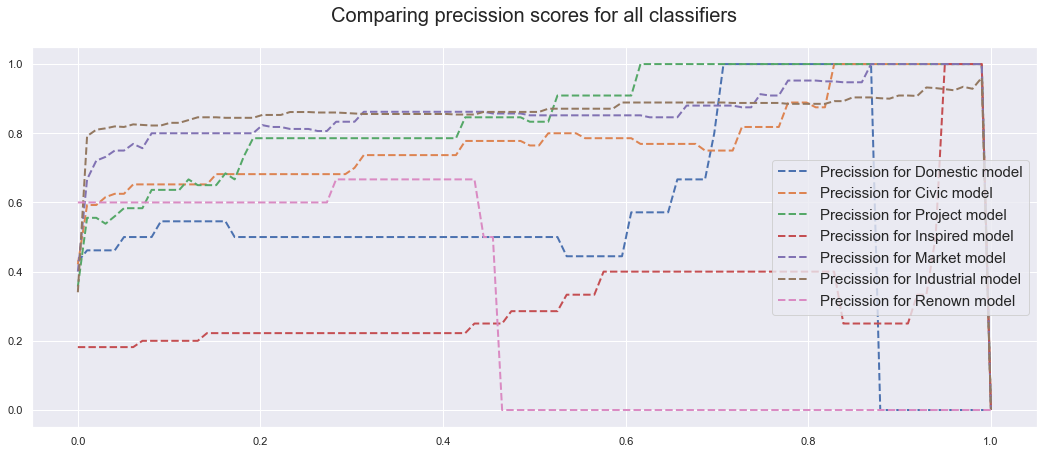

In [46]:
plt.figure(figsize=(18,7))



for k in _conventions_matches_precissions:
    x = thresholds
    y = _conventions_matches_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_conventions_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)


plt.show()

In [47]:
_conventions_models.keys()

dict_keys(['training_Domestic.txt', 'training_Civic.txt', 'training_Project.txt', 'training_Inspired.txt', 'training_Market.txt', 'training_Industrial.txt', 'training_Renown.txt'])

In [48]:
## To be removed once conv classifiers are more accurate\n",

valid_conv_keys = ['training_Project.txt', 'training_Industrial.txt', 'training_Market.txt', 'training_Domestic.txt']
tbr_tmp_conv_models = {}
tbr_tmp_cnv_matches = {}
for k in valid_conv_keys:
    tbr_tmp_conv_models[k] = _conventions_models[k]
    tbr_tmp_cnv_matches[k] = _conventions_matches_precissions[k]
_conventions_matches_precissions = tbr_tmp_cnv_matches
_conventions_models = tbr_tmp_conv_models

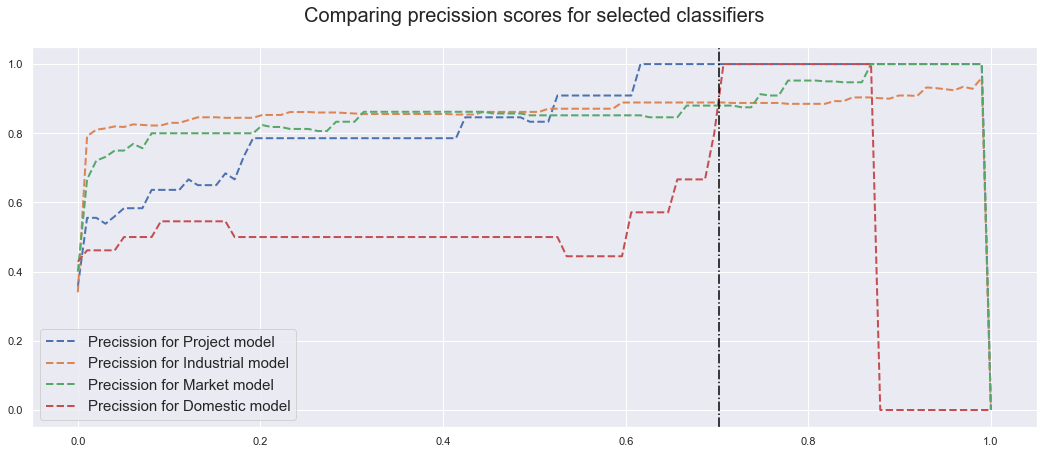

In [49]:
plt.figure(figsize=(18,7))

equalized_conv_precissions_threshold = 0.702

for k in _conventions_matches_precissions:
    x = thresholds
    y = _conventions_matches_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_conventions_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for selected classifiers", fontdict={'fontsize':20}, pad=25)
plt.axvline(x=equalized_conv_precissions_threshold, color='black', linestyle="-.")

plt.show()

#### So the threhsold for the conventions classifier will be **0.702**

### 4.1.2 Computing conventions matches

In [50]:
conventions_repos_matches = calculate_matches(df['cleaned_descriptions'].values, 
                                              _conventions_models, 
                                              _conventions_tokenizers,
                                             model_preds_func=count_positive_preds_with_threshold, 
                                             threshold = equalized_conv_precissions_threshold) ##As obtained above!




In [51]:
conventions_repos_matches[:2]

[[1, 5, 3, 2], [1, 20, 7, 7]]

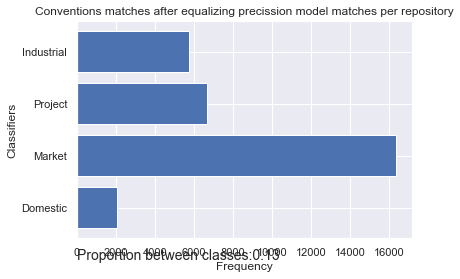

In [52]:
conv_freqs = plot_matches_histogram(conventions_repos_matches, _conventions_models, "Conventions matches after equalizing precission")
plt.text(2,-1,"Proportion between classes:{}".format("%.2f" % (conv_freqs[0]/conv_freqs[1])), fontsize=14)
plt.show()

## 4.2 Calculate classifications for characteristics_classifiers

### 4.2.1 Calibrating characteristics classifiers

In [53]:
thresholds = np.linspace(0,1,100)

_characteristics_matches_precissions = {}


for k in _characteristics_models.keys():
    
    tmp_precissions = []
    
    my_model = _characteristics_models[k]
    my_data_x = _characteristics_data_val_x[k]
    my_data_y = [int(x[0]<x[1]) for x in _characteristics_data_val_y[k]]

    preds = my_model.predict(my_data_x)
    
    for t in thresholds:
        y_pred = get_positive_preds_with_threshold(preds,t)
        
        tmp_precissions.append(metrics.precision_score(my_data_y, y_pred))
        

    _characteristics_matches_precissions[k] = tmp_precissions

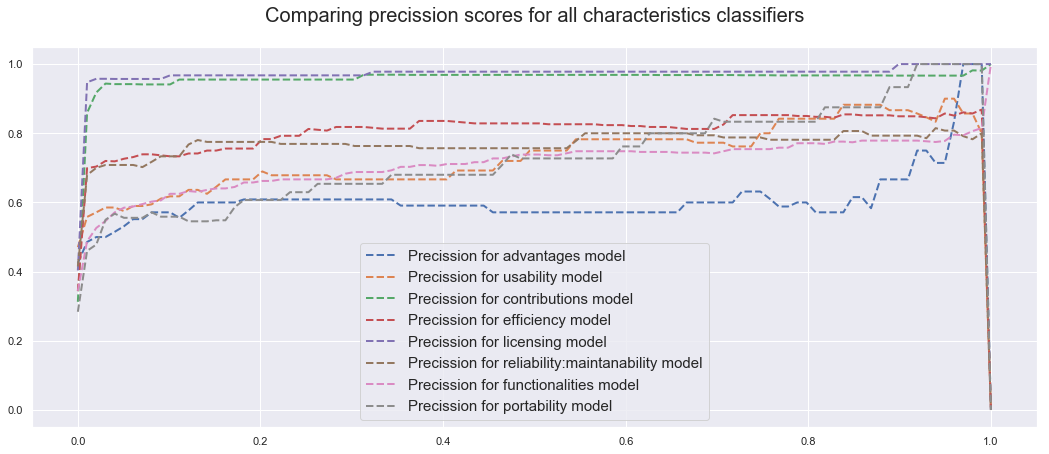

In [54]:
plt.figure(figsize=(18,7))



for k in _characteristics_matches_precissions:
    x = thresholds
    y = _characteristics_matches_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_characteristics_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for all characteristics classifiers", fontdict={'fontsize':20}, pad=25)


plt.show()

In [55]:
_characteristics_models.keys()

dict_keys(['training_advantages.txt', 'training_usability.txt', 'training_contributions.txt', 'training_efficiency.txt', 'training_licensing.txt', 'training_reliability:maintanability.txt', 'training_functionalities.txt', 'training_portability.txt'])

In [57]:
## To be removed once characteristics classifiers are more accurate\n",
valid_characteristics_keys = ['training_usability.txt', 'training_contributions.txt', 'training_efficiency.txt', 'training_licensing.txt', 'training_reliability:maintanability.txt', 'training_functionalities.txt', 'training_portability.txt']
tbr_tmp_chr_models = {}
tbr_tmp_chr_matches = {}
for k in valid_characteristics_keys:
    tbr_tmp_chr_models[k] = _characteristics_models[k]
    tbr_tmp_chr_matches[k] = _characteristics_matches_precissions[k]
_characteristics_matches_precissions = tbr_tmp_chr_matches
_characteristics_models = tbr_tmp_chr_models

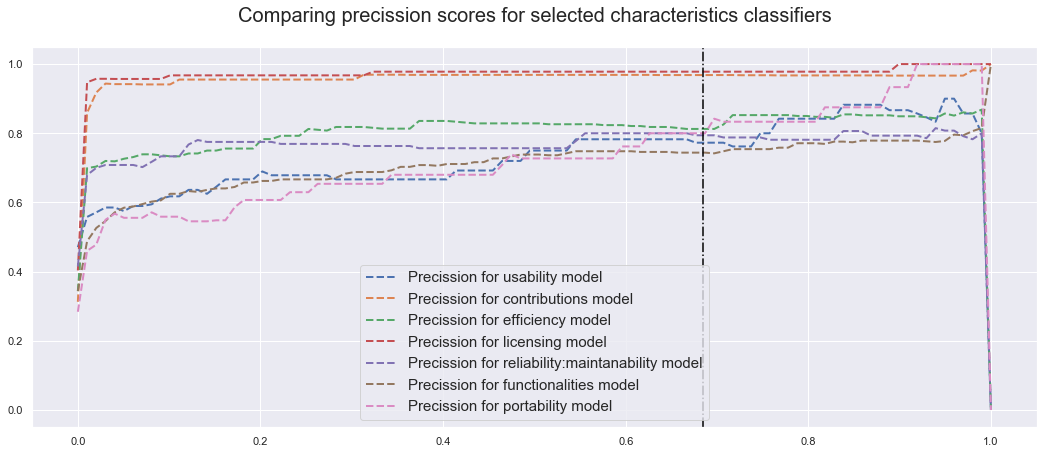

In [58]:
plt.figure(figsize=(18,7))
equalized_characteristics_precissions_threshold=0.685


for k in _characteristics_matches_precissions:
    x = thresholds
    y = _characteristics_matches_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_characteristics_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for selected characteristics classifiers", fontdict={'fontsize':20}, pad=25)
plt.axvline(x=equalized_characteristics_precissions_threshold, color='black', linestyle="-.")

plt.show()

### 4.2.2 Computing software characteristics matches

In [59]:
"""
characteristics_repos_matches = calculate_matches(df['cleaned_descriptions'].values, 
                                                  _characteristics_models, 
                                                  _characteristics_tokenizers)
"""

characteristics_repos_matches = calculate_matches(df['cleaned_descriptions'].values, 
                                              _characteristics_models, 
                                              _characteristics_tokenizers,
                                             model_preds_func=count_positive_preds_with_threshold, 
                                             threshold = equalized_characteristics_precissions_threshold) ##As obtained above!






In [60]:
characteristics_repos_matches[:2]

[[1, 5, 1, 1, 0, 5, 2], [9, 11, 3, 3, 3, 21, 6]]

array([ 5136,  7892,  4020,  2646,  2695, 15193,  2866])

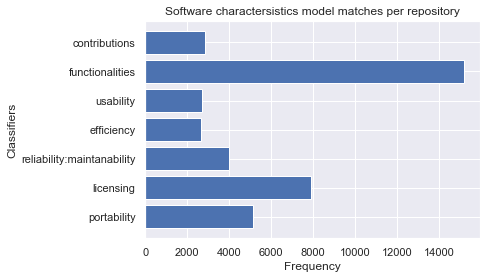

In [61]:
plot_matches_histogram(characteristics_repos_matches, _characteristics_models, "Software charactersistics")

# 5. Repositories clustering using classification results

In [62]:
def calculate_clusters(X, kmeans_k=4):#eps=0.3, min_samples=3):
    
    
    X = StandardScaler(with_mean=False).fit_transform(X)
    
    # #############################################################################
    # Compute Clustering
    clustering_model = KMeans(n_clusters=kmeans_k).fit(X)#eps=eps, min_samples=min_samples).fit(X)
    #core_samples_mask = np.zeros_like(clustering_model.labels_, dtype=bool)
    #core_samples_mask[clustering_model.core_sample_indices_] = True
    labels = clustering_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))

    # #############################################################################
    # Plot result

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    pca = PCA(n_components=2)
    pca.fit(X)
    X_pca = pca.fit_transform(X)
    print("original shape:   ", X.shape)
    print("transformed shape:", X_pca.shape)
    
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_pca[class_member_mask]# & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
        

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

## 5.1 Calculate clustering results for conventions and software characterstics

In [63]:
def get_repos_at_cluster(repo_names, clustering_labels, cluster_number, model_matches=None):
    cluster_indexes = np.where(clustering_labels == cluster_number)[0]
    
    print(" -- {} respositories at Cluster {} -- ".format(len(cluster_indexes), cluster_number))
    for i in cluster_indexes:
        if(model_matches is not None):
            
            print("   {} - {}".format(repo_names[i], model_matches[i]))
        else:
            print("   {}".format(repo_names[i]))

In [64]:
def get_descriptions_at_cluster(repo_descriptions, clustering_labels, cluster_number):
    
    cluster_descs = []
    
    cluster_indexes = np.where(clustering_labels == cluster_number)[0]
    
    print(" -- {} respositories at Cluster {} -- ".format(len(cluster_indexes), cluster_number))
    for i in cluster_indexes:
        cluster_descs.append(repo_descriptions[i])
    
    return cluster_descs

In [65]:
def get_data_indexes_at_cluster(clustering_labels, cluster_number):
    
    cluster_indexes = np.where(clustering_labels == cluster_number)[0]
    return cluster_indexes

In [66]:
def print_repo_description_by_name(repo_name, _df):
    for sent in _df[_df['repo_name'] == repo_name]['cleaned_descriptions'].values:
        print(sent+"\n")

### 5.1.1 Conventions matches clustering

In [67]:
repositories_names = df['repo_name'].values

Estimated number of clusters: 2
Estimated number of noise points: 0
Silhouette Coefficient: 0.802
original shape:    (832, 4)
transformed shape: (832, 2)


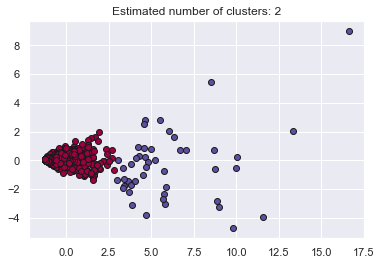

In [68]:
conventions_clusters = calculate_clusters(conventions_repos_matches, kmeans_k=2)

In [69]:
get_repos_at_cluster(repositories_names, conventions_clusters, 1, conventions_repos_matches)

 -- 46 respositories at Cluster 1 -- 
   terryum/awesome-deep-learning-papers - [43, 161, 42, 15]
   microsoft/CNTK - [12, 75, 26, 39]
   donnemartin/data-science-ipython-notebooks - [22, 108, 19, 20]
   ChristosChristofidis/awesome-deep-learning - [11, 167, 18, 24]
   mozilla/DeepSpeech - [9, 55, 36, 24]
   hangtwenty/dive-into-machine-learning - [17, 92, 24, 74]
   vahidk/EffectiveTensorflow - [12, 165, 93, 45]
   bharathgs/Awesome-pytorch-list - [65, 420, 43, 47]
   donnemartin/awesome-aws - [38, 218, 71, 80]
   aleju/imgaug - [5, 118, 67, 34]
   guess-js/guess - [8, 89, 47, 57]
   hanxiao/bert-as-service - [11, 144, 73, 69]
   humphd/have-fun-with-machine-learning - [16, 71, 29, 43]
   aymericdamien/TopDeepLearning - [11, 86, 41, 14]
   h2oai/h2o-3 - [23, 80, 53, 46]
   firmai/industry-machine-learning - [6, 147, 60, 27]
   gorgonia/gorgonia - [5, 80, 38, 29]
   openvenues/libpostal - [4, 64, 41, 29]
   TarrySingh/Artificial-Intelligence-Deep-Learning-Machine-Learning-Tutorials - [

### 5.1.2 Software characteristics matches clustering

Estimated number of clusters: 8
Estimated number of noise points: 0
Silhouette Coefficient: 0.471
original shape:    (832, 7)
transformed shape: (832, 2)


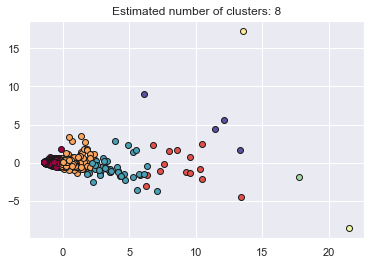

In [70]:
characteristics_clusters = calculate_clusters(characteristics_repos_matches, kmeans_k=8)#, eps=0.7, min_samples=3)

In [71]:
for i,k in enumerate(list(_characteristics_models.keys())):print("{}.- {}".format(i,k)) 

0.- training_usability.txt
1.- training_contributions.txt
2.- training_efficiency.txt
3.- training_licensing.txt
4.- training_reliability:maintanability.txt
5.- training_functionalities.txt
6.- training_portability.txt


In [72]:
for i,k in enumerate(list(_conventions_models.keys())):print("{}.- {}".format(i,k)) 

0.- training_Project.txt
1.- training_Industrial.txt
2.- training_Market.txt
3.- training_Domestic.txt


## 5.2 Compare obtained results for conventions and software characteristics

In [73]:
def get_conv_proportions_per_cluster(_clusters):

    ##Â Get which DF's indexes are in each cluster
    _indexes_per_cluster = {}
    _conv_matches_per_cluster = {}
    _conv_proportions_per_cluster = {}

    for c in set(_clusters):
        _indexes_per_cluster[c] = get_data_indexes_at_cluster(_clusters, c)

    for ck in _indexes_per_cluster.keys():
        tmp_array = []
        for idx in _indexes_per_cluster[ck]:
            tmp_array.append(conventions_repos_matches[idx])

        _conv_matches_per_cluster[ck] = tmp_array


    for ck2 in list(_conv_matches_per_cluster.keys()):
        tmp_matches = _conv_matches_per_cluster[ck2]
        tmp_num_matches = []
        for x in range(len(tmp_matches[0])):
        
            tmp_num_matches.append(sum([i[x] for i in tmp_matches]))
        

        _conv_proportions_per_cluster[ck2] = tmp_num_matches
    
    return _conv_proportions_per_cluster


In [74]:
def plot_conv_proportions_per_cluster(conv_proportions, conv_models):
    
    

    labels =[k.replace("training_", "").replace(".txt", "") for k in list(conv_models.keys())]
    
    cidx = 0
    
    
    num_convs = len(labels)
    num_clusters = len(conv_proportions)
    
    fig, axs = plt.subplots(2,int(num_clusters/2), figsize=[14,14])

    fig.suptitle('Conventions ratio per cluster', fontsize=20)
    
    
    for c in conv_proportions.keys():

        x = int(cidx/int(num_clusters/2))
        y = cidx%int(num_clusters/2)

        vs = conv_proportions[c]

        axs[x][y].barh(labels,vs)
        axs[x][y].set_title('Cluster: {}'.format(cidx))

        cidx +=1

    #fig.delaxes(axs[2][2])    

    plt.show()
    

#### 5.2.1 Compute proportion of conventions matches per each software characteristic matches cluster

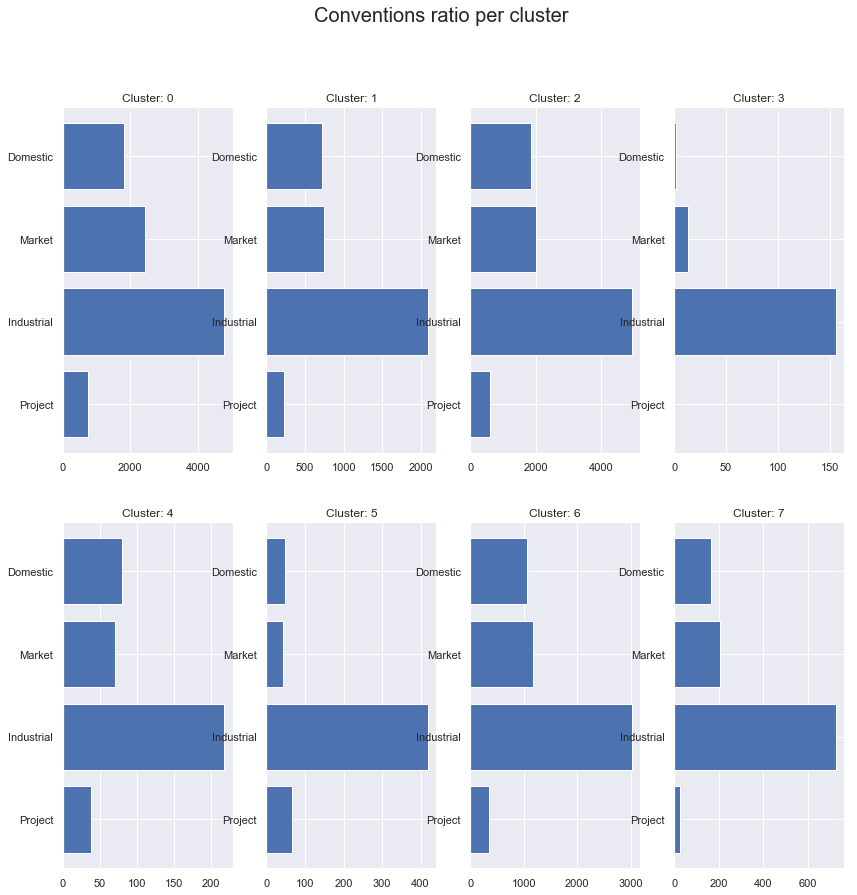

In [77]:
conv_proportions_per_characteristics_cluster = get_conv_proportions_per_cluster(characteristics_clusters)
plot_conv_proportions_per_cluster(conv_proportions_per_characteristics_cluster, _conventions_models)

##### Cluster 3 looks very interesting because of its proportion of conventions, let's take a look:

In [78]:
get_repos_at_cluster(repositories_names, characteristics_clusters, 3, characteristics_repos_matches)

 -- 1 respositories at Cluster 3 -- 
   huseinzol05/NLP-Models-Tensorflow - [7, 208, 60, 154, 5, 80, 1]


In [79]:
print_repo_description_by_name("ChristosChristofidis/awesome-deep-learning", df)

b awesome deep learning table of contents free online books courses videos and lectures papers tutorials researchers websites datasets conferences frameworks tools miscellaneous contributing free online books1.
deep learning by yoshua bengio, ian goodfellow and aaron courville 05 07 2015 2. neural networks and deep learning by michael nielsen dec 2014 3. deep learning by microsoft research 2013 4. deep learning tutorial by lisa lab, university of montreal jan 6 2015 5. neuraltalk by andrej karpathy numpy-based rnn lstm implementation6.
an introduction to genetic algorithms7.
artificial intelligence a modern approach8.
deep learning in neural networks an overview9.
artificial intelligence and machine learning topic wise explanation courses1.
machine learning - stanford by andrew ng in coursera 2010-2014 2. machine learning - caltech by yaser abu-mostafa 2012-2014 3. machine learning - carnegie mellon by tom mitchell spring 2011 2. neural networks for machine learning by geoffrey hinton 

In [80]:
print_repo_description_by_name("bharathgs/Awesome-pytorch-list", df)

b awesome-pytorch-list t t contents- pytorch related libraries - nlp speech processing - computer vision - probabilistic generative libraries - other libraries- tutorials examples- paper implementations- talks conferences- pytorch elsewhere pytorch related libraries1.
pytorch tensors and dynamic neural networks in python with strong gpu acceleration.
nlp speech processing 1. pytorch text torch text related contents.
2. pytorch-seq2seq a framework for sequence-to-sequence seq2seq models implemented in pytorch.
3. anuvada interpretable models for nlp using pytorch.4.
audio simple audio i o for pytorch.5.
loop a method to generate speech across multiple speakers6.
fairseq-py facebook ai research sequence-to-sequence toolkit written in python.7.
speech pytorch asr implementation.8.
opennmt-py open-source neural machine translation in pytorch http opennmt.net 9. neuralcoref state-of-the-art coreference resolution based on neural nets and spacy huggingface.co coref10.
sentiment-discovery uns

### 5.2.2 Compute correlations between conventions software characteristics matches

In [136]:
matches_matrix = []
matches_matrix_labels = []
for i, k in enumerate(_conventions_models.keys()):
    matches_matrix.append(np.array(conventions_repos_matches)[:,i])
    matches_matrix_labels.append(k.replace("training_", "").replace(".txt", ""))
    
for i, k in enumerate(_characteristics_models.keys()):
    matches_matrix.append(np.array(characteristics_repos_matches)[:,i])
    matches_matrix_labels.append(k.replace("training_", "").replace(".txt", ""))
    

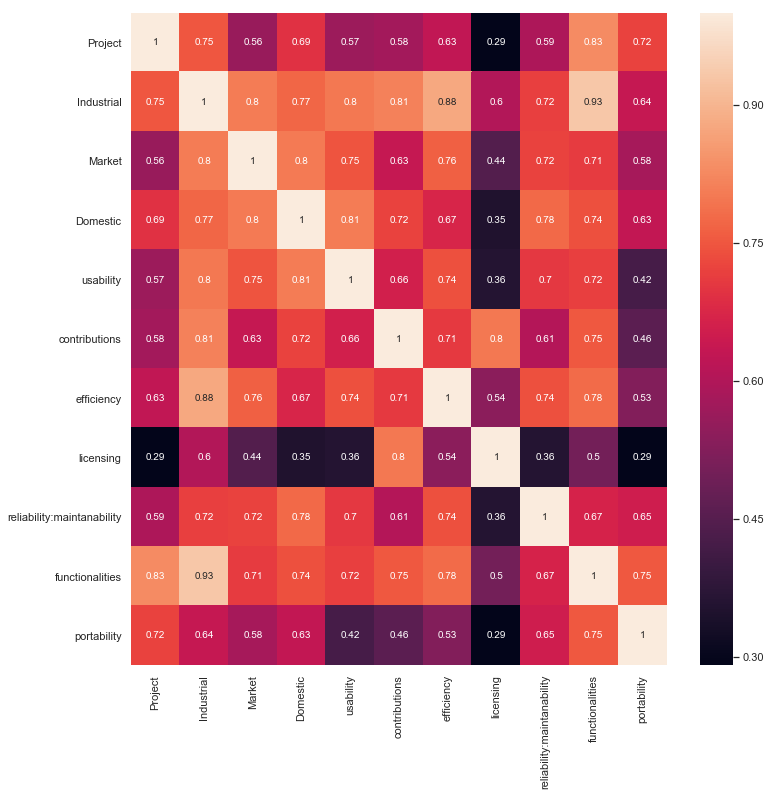

In [137]:
plt.figure(figsize=[12,12])
ax = sns.heatmap(np.corrcoef(matches_matrix), xticklabels=matches_matrix_labels, yticklabels=matches_matrix_labels, annot=True)
plt.show()

## 6. Calcultate clusters based on description topics

### 6.1 Get doc2vec representation of each repository

In [81]:
d2v_training_data = ["\n".join(d) for d in df['cleaned_descriptions'].values]
d2v_tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(d2v_training_data)]

In [82]:
if FLAG__RETRAIN_DOC2VEC_MODEL:

    max_epochs = 100
    vec_size = 20
    alpha = 0.025

    d2v_model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha, 
                    min_alpha=0.00025,
                    min_count=1,
                    dm =1)

    d2v_model.build_vocab(d2v_tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        d2v_model.train(d2v_tagged_data,
                    total_examples=d2v_model.corpus_count,
                    epochs=d2v_model.epochs)
        # decrease the learning rate
        d2v_model.alpha -= 0.0002
        # fix the learning rate, no decay
        d2v_model.min_alpha = d2v_model.alpha

#### 6.1.1 Store Doc2Vec Model in a file

In [83]:
if FLAG__RETRAIN_DOC2VEC_MODEL:
    d2v_model.save(os.path.join(BASE_DIR,"d2v_12_08_2019_github.model"))
    print("Model Saved")

#### 6.1.2 Read Doc2Vec model from file

In [84]:
d2v_model = Doc2Vec.load(os.path.join(BASE_DIR,"d2v_12_08_2019_github.model"))

In [85]:
## Examples of use of Doc2Vec Model

#to find the vector of a document which is not in training data
test_data = word_tokenize("I love chatbots".lower())
v1 = d2v_model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = d2v_model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(d2v_model.docvecs['1'])

V1_infer [-5.7726824e-03 -2.1146588e-02  1.5960708e-02 -6.8325746e-05
  2.2729076e-02  1.9021265e-02 -1.4182367e-02 -4.2219777e-03
  5.4697166e-03  6.7840359e-04 -1.7680394e-02  1.0403605e-02
 -3.0962925e-03 -5.8596893e-03  2.6587091e-04  1.2116765e-02
 -1.1164854e-02  5.8555370e-03  2.2206010e-02  1.9012081e-02]
[('148', 0.7980687022209167), ('278', 0.7663114070892334), ('162', 0.733460545539856), ('144', 0.7080360651016235), ('223', 0.6881098747253418), ('38', 0.6718860864639282), ('108', 0.6637601852416992), ('199', 0.6549744009971619), ('159', 0.6425496935844421), ('214', 0.6372202038764954)]
[ 2.3297482   0.48505297 -1.0270667  -3.2380257  -0.24994625  0.80723643
 -0.15573238 -0.63294363  4.5593266  -2.005868    1.8001387  -0.6261838
 -0.59172314 -0.42919704 -1.2119243  -1.6726727   0.9575692   0.02320477
  1.897162    0.3978433 ]


#### 6.2 Cluster doc embeddings

In [86]:
def absolute_value(val):
    return int(np.round(((val/100)*df.size),0))

In [87]:
doc_vecs = []

for doc in d2v_training_data:
    doc_vecs.append(d2v_model.infer_vector(doc.split()))
# creating a matrix from list of vectors
mat = np.stack(doc_vecs)

# Clustering Kmeans
km_model = nltk.cluster.KMeansClusterer(8, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
topics_kmeans_cos_labels = km_model.cluster(mat, assign_clusters=True)

topics_kmeans_cos_labels = np.array(topics_kmeans_cos_labels)

In [88]:
df['cluter_kmeans_cosine'] = topics_kmeans_cos_labels

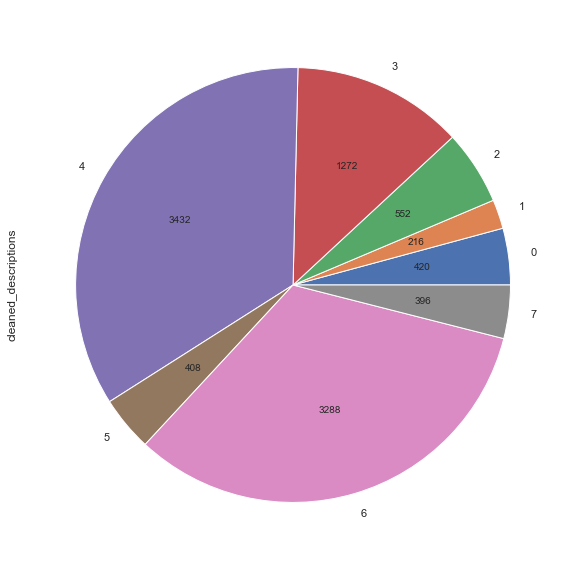

In [89]:
# Check count of news articles in each cluster
df.groupby("cluter_kmeans_cosine")["cleaned_descriptions"].count().plot(
    kind = "pie", 
    autopct=absolute_value, 
    figsize = (10, 10))



#### 6.2.1 Get conventions ratio per topics cluster

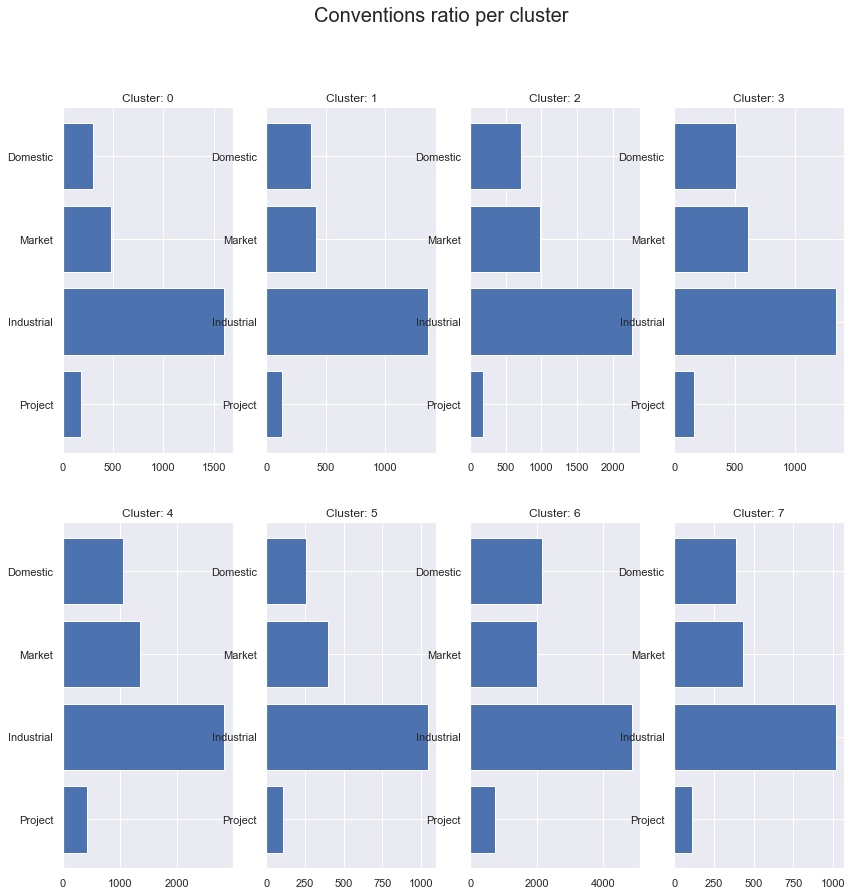

In [90]:
conv_proportions_per_topics_cluster = get_conv_proportions_per_cluster(topics_kmeans_cos_labels)
plot_conv_proportions_per_cluster(conv_proportions_per_topics_cluster, _conventions_models)

In [91]:
get_repos_at_cluster(repositories_names, topics_kmeans_cos_labels, 3, conventions_repos_matches)

 -- 106 respositories at Cluster 3 -- 
   kailashahirwar/cheatsheets-ai - [0, 1, 1, 0]
   chiphuyen/stanford-tensorflow-tutorials - [0, 2, 1, 0]
   facebookarchive/caffe2 - [0, 2, 0, 0]
   Hironsan/BossSensor - [1, 3, 1, 0]
   wiseodd/generative-models - [0, 4, 2, 1]
   Yorko/mlcourse.ai - [0, 30, 3, 3]
   BinRoot/TensorFlow-Book - [1, 3, 1, 3]
   h2oai/h2o-3 - [23, 80, 53, 46]
   tensorspace-team/tensorspace - [3, 21, 7, 5]
   xviniette/FlappyLearning - [0, 0, 1, 0]
   lyst/lightfm - [3, 7, 7, 2]
   d2l-ai/d2l-en - [0, 0, 0, 2]
   rlcode/reinforcement-learning - [0, 4, 0, 1]
   biolab/orange3 - [0, 6, 4, 1]
   lakshayg/tensorflow-build - [0, 3, 2, 1]
   robi56/Deep-Learning-for-Recommendation-Systems - [5, 40, 5, 7]
   shimat/opencvsharp - [2, 7, 6, 0]
   abhshkdz/ai-deadlines - [0, 2, 1, 1]
   keithito/tacotron - [3, 32, 10, 10]
   dragen1860/TensorFlow-2.x-Tutorials - [1, 7, 3, 1]
   ARM-software/ComputeLibrary - [1, 1, 3, 2]
   pkmital/CADL - [10, 54, 44, 39]
   hanleyweng/CoreML-i

## 7. Compare topics clustering and software characteristics clusters

**Jaccard similarity coefficient score**

The Jaccard index, or Jaccard similarity coefficient, defined as the size of the intersection divided by the size of the union of two label sets, is used to compare set of predicted labels for a sample to the corresponding set of labels in y_true.

In [92]:
## Testing Jaccard similarity
y_true = np.array([[1, 1, 1],
                   [1, 1, 0],
                   [0, 0, 1]])
y_pred = np.array([[0, 1, 1],
                   [1, 1, 0],
                   [1, 1, 0]])

print("Score1: {}".format(metrics.jaccard_score(y_true[0], y_pred[0])))
print("Score2: {}".format(metrics.jaccard_score(y_true[1], y_pred[1])))
print("Score3: {}".format(metrics.jaccard_score(y_true[2], y_pred[2]))) ##Â Should return 1 but it gives a zero!

Score1: 0.6666666666666666
Score2: 1.0
Score3: 0.0


<div class="alert alert-block alert-warning text-center">
<b>IMPORTANT!</b>
<br>
    <br>
JACCARD IMPLEMENTATION DEPENDS ON ASSIGNED LABELS!
        <br>
</div>

**micro**

Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [93]:
metrics.jaccard_score(characteristics_clusters, topics_kmeans_cos_labels, average="macro")

0.023173295922994476

**macro**

Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

In [94]:
metrics.jaccard_score(characteristics_clusters, topics_kmeans_cos_labels, average="micro")

0.030340557275541795

**weighted**

Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters â€˜macroâ€™ to account for label imbalance.

In [95]:
metrics.jaccard_score(characteristics_clusters, topics_kmeans_cos_labels, average="weighted")

0.0402188164679614

### 7.1 Get new cluster labeling that maximizes jaccard similarity between both clusterings

In [96]:
def pivot_array_indexes(arr, val1, val2):
    tmp_arr = arr.copy()
    tmp_arr[np.where(tmp_arr==val1)] = -99

    tmp_arr[np.where(tmp_arr==val2)] = val1
    tmp_arr[np.where(tmp_arr==-99)] = val2
    
    return tmp_arr
    

In [97]:
def get_indexes_at_perms(current_path):
    
    if(current_path == []):
        return []
    l=[]
    
    for c in current_path:
        l.append(c[0])
        l.append(c[1])
    return l

get_indexes_at_perms([(0,1), (2,3)])



[0, 1, 2, 3]

In [98]:
def get_valid_combinations(combinations, current_path):

    valid_combs = []
    
    already_used_values = get_indexes_at_perms(current_path)
    
    for c in combinations:
        if c[0] not in already_used_values and c[1] not in already_used_values:
            valid_combs.append(c)

    return valid_combs

print(get_valid_combinations([(1,2),(3,4)], []))
print(get_valid_combinations([(1,2),(3,4)], [(1,2)]))

[(1, 2), (3, 4)]
[(3, 4)]


In [99]:
def generate_permutations(combinations, current_path = [], perms = None):
    if perms is None:
        perms = []
        perms.append([])
        for c in combinations:
            current_path = [c]
            perms.append(current_path.copy())
            perms = generate_permutations(combinations, current_path, perms)
    else:
        for c in get_valid_combinations(combinations, current_path):
            current_path_tmp = current_path.copy()
            current_path_tmp.append(c)
            perms.append(current_path_tmp.copy())
            perms = generate_permutations(combinations, current_path_tmp, perms)
            
    return perms

In [100]:
## Testing permutations generation
a=np.array([1,2,3])

combss = list(itertools.combinations(a, 2))
tmp_per = generate_permutations(combss)
print(tmp_per)
len(tmp_per)
    

[[], [(1, 2)], [(1, 3)], [(2, 3)]]


4

In [101]:
## Let's change assigned labels numbers in topics clustering
## Looking for the asignation that maximizes the jaccard score
def get_most_optimal_jaccard(clustering1, clustering2, jaccard_metric=None):
    clustering1 = np.array(clustering1)
    clustering2 = np.array(clustering2)
    
    best_asignation = clustering2.copy()
    
    max_jaccard=0
    best_asignation = []

    all_numbers = list(set(clustering1)) + list(set(clustering2))
    possible_combinations = list(itertools.combinations(list(set(clustering2)), 2))

    available_permutations = generate_permutations(possible_combinations)
    
    for path in available_permutations:
        tmp_clustering2 = clustering2.copy()
        for c_idx, c in enumerate(path):
            tmp_clustering2 = pivot_array_indexes(tmp_clustering2, c[0], c[1])
        
        if jaccard_metric is None:
            current_jaccard = metrics.jaccard_score(clustering1, tmp_clustering2)
        else:
            current_jaccard = metrics.jaccard_score(clustering1, tmp_clustering2, average=jaccard_metric)

        if current_jaccard> max_jaccard:
            best_asignation = tmp_clustering2.copy()
            max_jaccard = current_jaccard
                
    #print("Best asignation: ", best_asignation)
    #print("Max jaccard: ", max_jaccard)
    return max_jaccard,best_asignation
            

In [102]:
## Testing custom Jaccard similarity
y_true = np.array([[1, 0, 0],
                   [0, 0, 1]])
y_pred = np.array([[0, 1, 1],
                   [1, 1, 0]])

print("Score1: ",get_most_optimal_jaccard(y_true[0], y_pred[0]))
print("Score2: ",get_most_optimal_jaccard(y_true[1], y_pred[1]))

Score1:  (1.0, array([1, 0, 0]))
Score2:  (1.0, array([0, 0, 1]))


In [103]:
get_most_optimal_jaccard(characteristics_clusters, topics_kmeans_cos_labels, "macro")[0]

0.09463516069464023

In [104]:
get_most_optimal_jaccard(characteristics_clusters, topics_kmeans_cos_labels, "micro")[0]

0.23809523809523808

In [105]:
get_most_optimal_jaccard(characteristics_clusters, topics_kmeans_cos_labels, "weighted")[0]

0.3157876528691641

In [140]:
len(df)

832